In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Sep  9 22:18:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 1024
n_outputs = 61
n_frames = 400

In [4]:
from model.model_ecapa_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs)
model = model.to(device)
model.eval()
print('done')

done


In [5]:
!ls -lt /data/scpark/save/lips/train08.28-5/

total 3533192
-rw-rw-r-- 1 scpark scpark     50887  8월 31 14:12 events.out.tfevents.1693330988.GPUSVR01
-rw-rw-r-- 1 scpark scpark 602982156  8월 31 13:06 save_50000
-rw-rw-r-- 1 scpark scpark 602982156  8월 31 06:21 save_40000
-rw-rw-r-- 1 scpark scpark 602982156  8월 30 23:36 save_30000
-rw-rw-r-- 1 scpark scpark 602982156  8월 30 16:50 save_20000
-rw-rw-r-- 1 scpark scpark 602982156  8월 30 09:50 save_10000
-rw-rw-r-- 1 scpark scpark 602982156  8월 30 02:44 save_0


In [6]:
path = '/data/scpark/save/lips/train08.28-5/save_50000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [8]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 zeroone scpark  1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark  vivernd 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark  vivernd 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 zeroone scpark  1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 zeroone scpark  1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 zeroone scpark   983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 zeroone scpark   971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 zeroone scpark   954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 zeroone scpark   944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 zeroone scpark   944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 zeroone scpark   928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 zeroone scpark   920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 zeroone scpark   920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 zeroone scpark   917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 zeroone scpark   917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 zeroone scpark   913841  5월 11 19:48 1098.sp

In [9]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


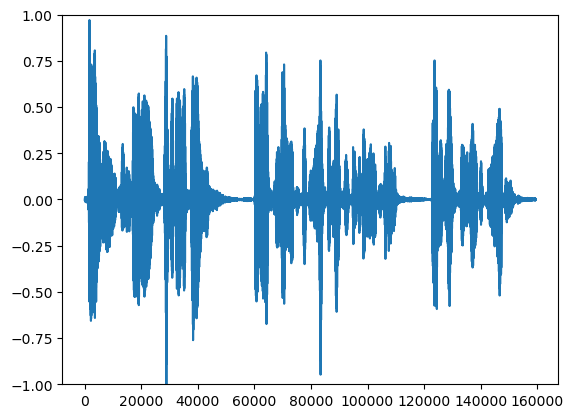

In [20]:
import matplotlib.pyplot as plt
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
#wav_file = 'samples/good.wav'
#wav_file = '/Storage/speech/eng_celeb2/ref/Barack_Obama/Barack_Obama.wav'
#wav_file = "/Storage/speech/eng_celeb2/ref/Donald_Trump/Donald_Trump_announces_he's_running_for_U.S._president_-_Full_speech-6OlfQvVrSOw_10.wav"
#wav_file = '/Storage/speech/eng_celeb2/ref/Benedict_Cumberbatch/Benedict_Cumberbatch.wav'
#wav_file = '/Storage/speech/eng_celeb2/ref/Emma_Watson/Emma_Watson.wav'
#wav_file = '/Storage/speech/eng_celeb2/ref/Oprah_Winfrey/Oprah_Winfrey.wav'
#wav_file = '/Storage/speech/eng_celeb2/ref/Scarlett_Johansson/Scarlett_Johansson.wav'
wav_file = '/Storage/speech/eng_celeb2/ref/Steve_Jobs/Steve_Jobs.wav'
#wav_file = '/Storage/speech/eng_celeb2/ref/Tom_Holland/Tom_Holland.wav'

wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

import IPython.display as ipd
ipd.Audio(wav, rate=16000)

In [21]:
def get_blendshape(wav, speaker, layer=12):
    with torch.no_grad():
        wav = torch.Tensor(wav).unsqueeze(0).to(device)
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
        states = F.interpolate(states, scale_factor=3/5, mode='linear').detach()
    speaker = torch.Tensor(speaker).unsqueeze(0).to(device)
    with torch.no_grad():
        y = model.inference(states, speaker)
        y = torch.clamp(y, min=0, max=1)
    y = y[0].data.cpu().numpy()
    print(wav.shape, y.shape)
    return y
    
#speaker = np.array([5.94, -11.96])
speaker = np.array([0.0, 0.0])
y = get_blendshape(wav, speaker)

np.save('samples/infer08.28-5.npy', y)
print('done')

torch.Size([1, 159544]) (61, 298)
done


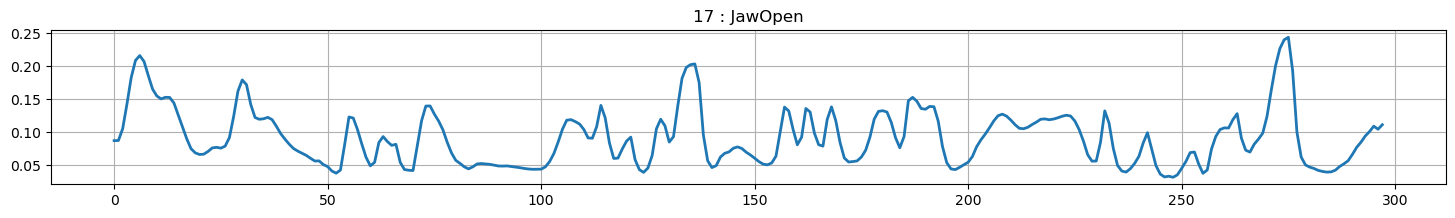

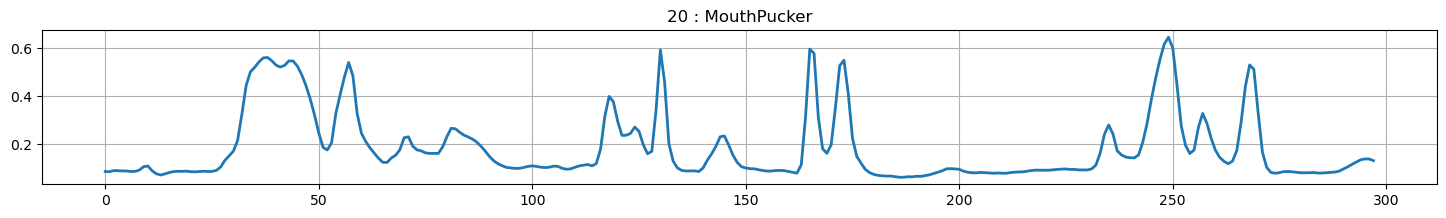

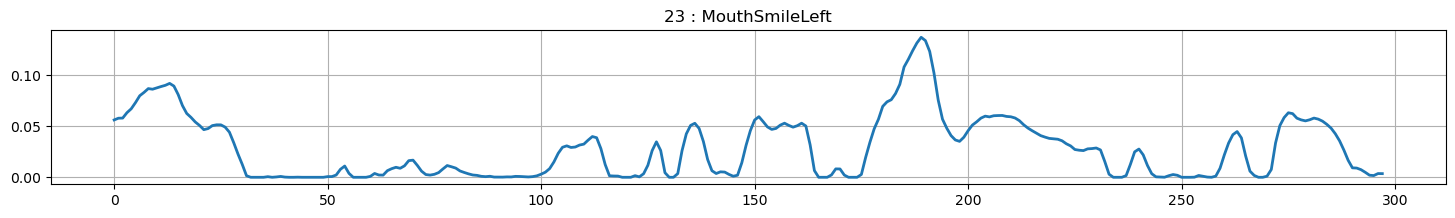

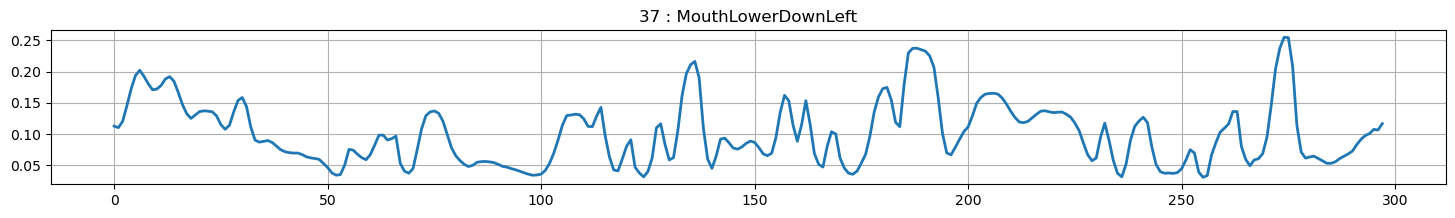

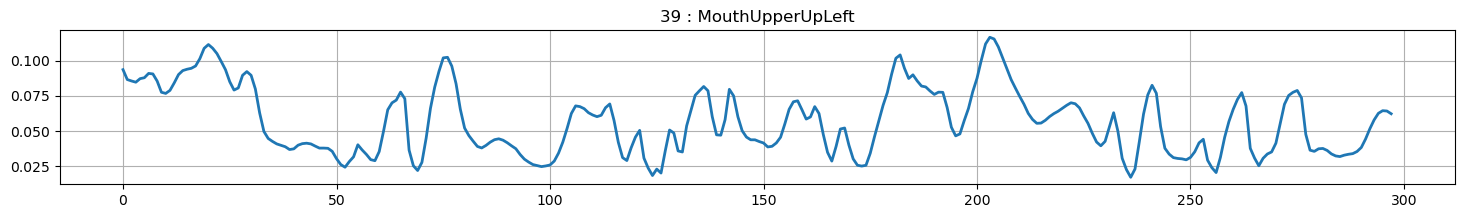

In [22]:
targets = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft'), (39, 'MouthUpperUpLeft')]

for target in targets:
    plt.figure(figsize=[18, 2])
    plt.title(str(target[0]) + ' : ' + target[1])
    plt.plot(y[target[0]], linewidth=2)
    plt.grid()
    plt.show()

### Grid

In [21]:
def generate_2d_array(x_start, x_end, x_step, y_start, y_end, y_step):
    x_points = list(range(x_start, x_end + 1, x_step))
    y_points = list(range(y_start, y_end + 1, y_step))
    
    array = np.array([(x, y) for x in x_points for y in y_points])
    return array


(81, 61, 397)


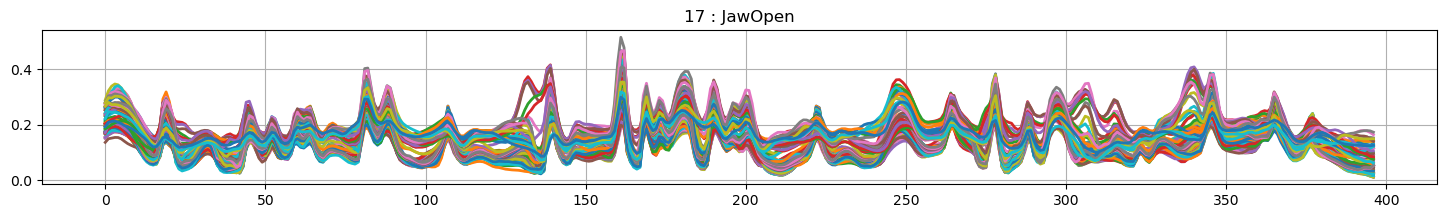

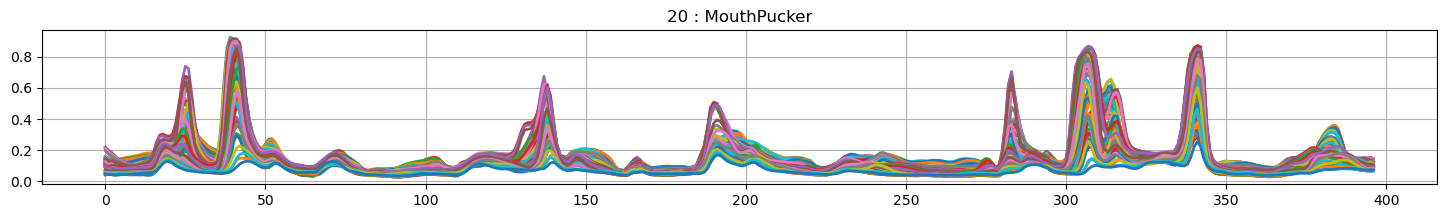

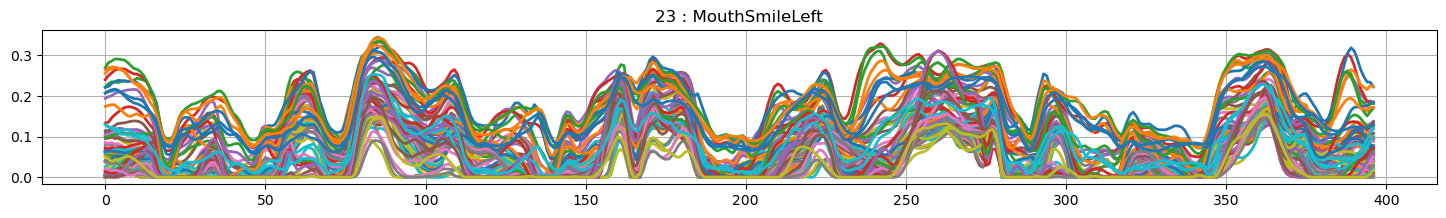

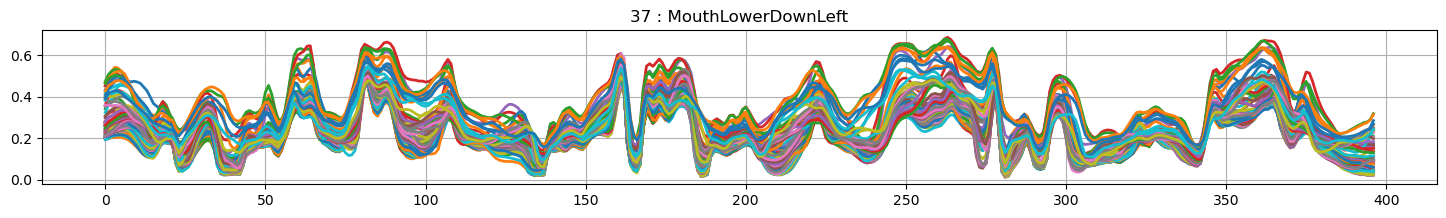

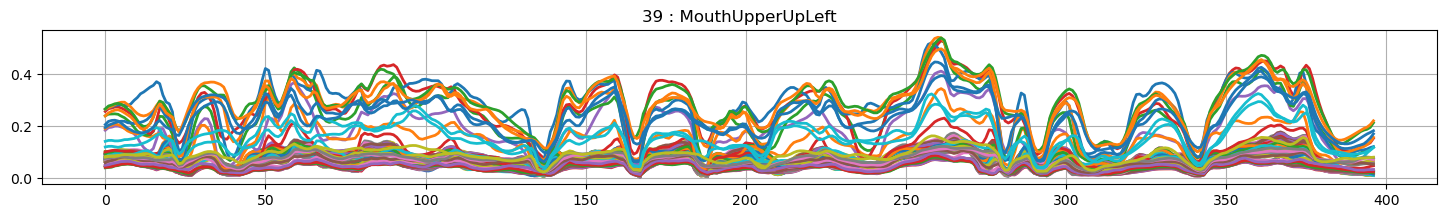

In [24]:
import numpy as np

speaker = generate_2d_array(-20, 20, 5, -20, 20, 5)
with torch.no_grad():
    states = wav2vec(torch.Tensor(wav).unsqueeze(0).to(device), output_hidden_states=True).hidden_states[12].transpose(1, 2)
    states = F.interpolate(states, scale_factor=3/5, mode='linear').detach()

with torch.no_grad():
    y = model.inference(states, torch.Tensor(speaker).to(device))
    y = torch.clamp(y, min=0, max=1)
y = y.data.cpu().numpy()    
print(y.shape)

targets = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft'), (39, 'MouthUpperUpLeft')]

for target in targets:
    plt.figure(figsize=[18, 2])
    plt.title(str(target[0]) + ' : ' + target[1])
    for i in range(len(y)):
        plt.plot(y[i, target[0]], linewidth=2)
    plt.grid()
    plt.show()

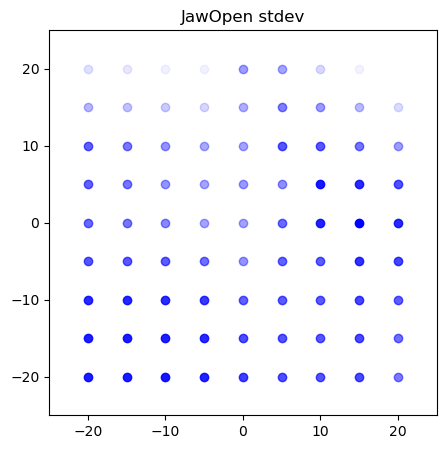

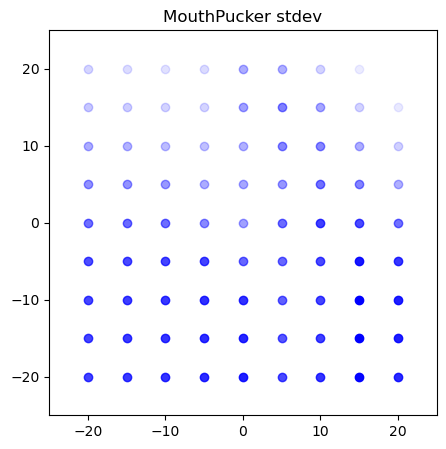

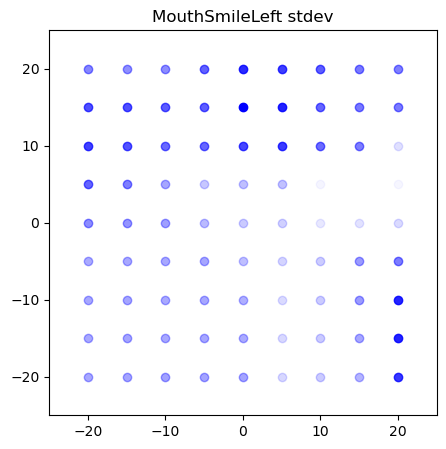

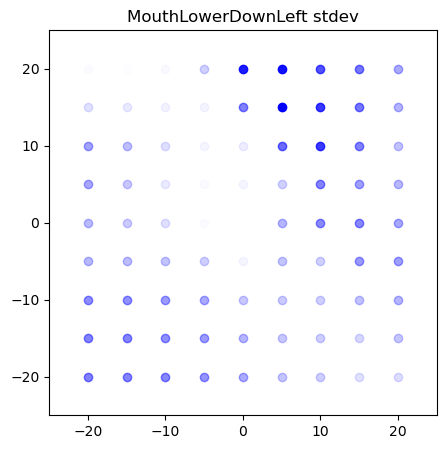

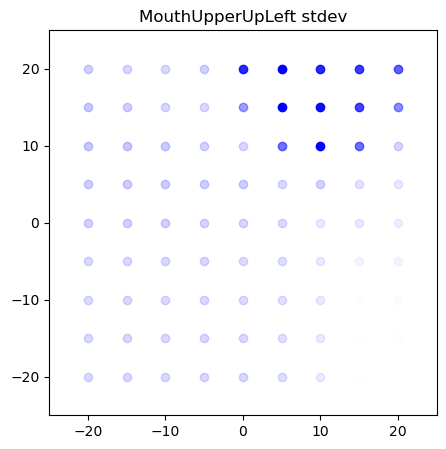

In [25]:
for target in targets:
    std = y[:, target[0]].std(axis=1)
    std = (std - std.min()) / (std.max() - std.min())

    plt.figure(figsize=[5, 5])
    plt.title(target[1] + ' stdev')
    for i in range(len(speaker)):
        plt.scatter(speaker[i, 0], speaker[i, 1], alpha=std[i], color='blue')
    plt.xlim([-25, 25])
    plt.ylim([-25, 25])
    plt.show()

### dataset

In [27]:
from data.arkit_dataset import LipsDataset

npy_files = ['/data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/kyuchulLee/MH_ARKit_006_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/kyuseokKim/MH_ARKit_002_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/nohsikPark/MH_ARKit_010_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/soochulPark/MH_ARKit_004_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/yehunHwang/MH_ARKit_001_1_iPhone_raw.npy']

datasets = []
for i, npy_file in enumerate(npy_files):
    print(npy_file)
    dataset = LipsDataset(npy_file, n_mels, n_frames, sid=0, mel=False)
    datasets.append(dataset)
    
len(datasets)

/data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/kyuchulLee/MH_ARKit_006_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/kyuseokKim/MH_ARKit_002_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/nohsikPark/MH_ARKit_010_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/soochulPark/MH_ARKit_004_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/yehunHwang/MH_ARKit_001_1_iPhone_raw.npy


7

In [28]:
n_samples = 10
targets = []
for i, dataset in enumerate(datasets):
    print(i)
    for j in range(n_samples):
        data_index = np.random.randint(0, len(dataset))
        data = dataset[data_index]
        target = torch.Tensor(data['blend'])
        targets.append(target)
    
targets = torch.stack(targets, dim=0).transpose(1, 2).to(device)
print(targets.shape)

0
1
2
3
4
5
6
torch.Size([70, 61, 400])


In [29]:
model.eval()
with torch.no_grad():
    outputs = model.get_speaker_embedding(targets)

print(outputs['speaker'].shape)

torch.Size([70, 2])


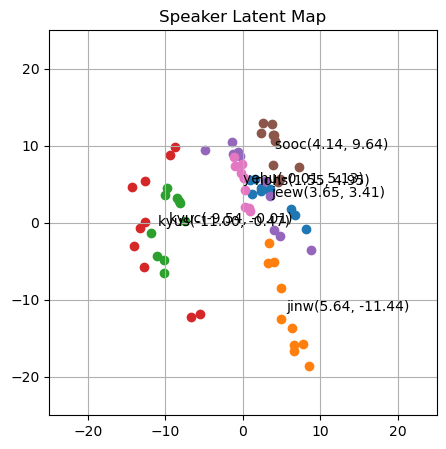

In [32]:
speaker = outputs['speaker'].data.cpu().numpy()

import matplotlib.pyplot as plt

names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
plt.figure(figsize=[5, 5])
plt.title('Speaker Latent Map')
for i in range(7):
    plt.scatter(speaker[i*n_samples:(i+1)*n_samples, 0], speaker[i*n_samples:(i+1)*n_samples, 1])
    mean = np.mean(speaker[i*n_samples:(i+1)*n_samples], axis=0)
    plt.text(mean[0], mean[1], names[i][:4] + "({:.2f}, {:.2f})".format(mean[0], mean[1]))
plt.xlim([-25, 25])
plt.ylim([-25, 25])    
plt.grid()
plt.show()

In [31]:
4.94, 9.39

(4.94, 9.39)